Epoch 1 | Train Acc: 0.6402 | Val Acc: 0.8148
Epoch 2 | Train Acc: 0.8598 | Val Acc: 0.9259
Epoch 3 | Train Acc: 0.9233 | Val Acc: 0.9383
Epoch 4 | Train Acc: 0.9365 | Val Acc: 0.9506
Epoch 5 | Train Acc: 0.9365 | Val Acc: 0.9506
Epoch 6 | Train Acc: 0.9550 | Val Acc: 0.9383
Epoch 7 | Train Acc: 0.9709 | Val Acc: 0.9506
Epoch 8 | Train Acc: 0.9709 | Val Acc: 0.9506
Epoch 9 | Train Acc: 0.9709 | Val Acc: 0.9506
Epoch 10 | Train Acc: 0.9709 | Val Acc: 0.9506
Epoch 11 | Train Acc: 0.9683 | Val Acc: 0.9506
Epoch 12 | Train Acc: 0.9735 | Val Acc: 0.9506
Epoch 13 | Train Acc: 0.9709 | Val Acc: 0.9506
Early stopping triggered.

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        41
           1       0.95      0.97      0.96        40

    accuracy                           0.96        81
   macro avg       0.96      0.96      0.96        81
weighted avg       0.96      0.96      0.96        81

Cohen Kappa Score: 0

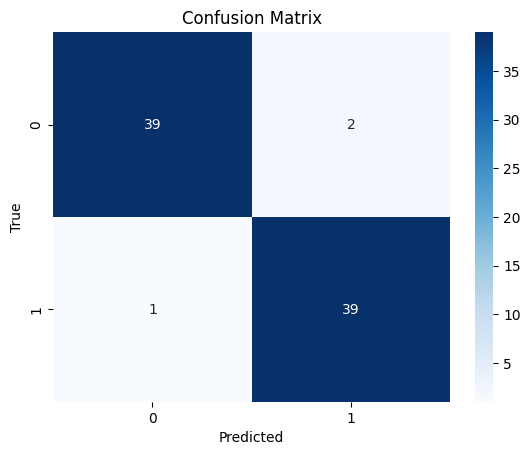

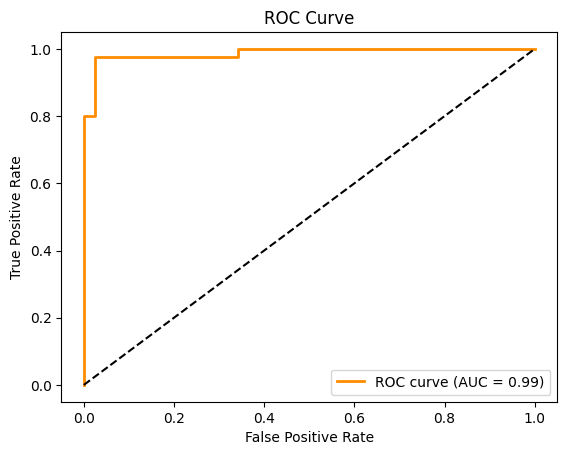


Sample predictions (5 samples):
Sample 1 | Predicted: YES | Confidence: 1.00
Sample 2 | Predicted: NO | Confidence: 0.01
Sample 3 | Predicted: YES | Confidence: 0.95
Sample 4 | Predicted: YES | Confidence: 0.98
Sample 5 | Predicted: NO | Confidence: 0.01


In [1]:
# Install if needed in Colab
# !pip install torch scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, cohen_kappa_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the dataset
df = pd.read_csv('/kaggle/input/lung-cancer-csv/balanced_lung_cancer (1).csv')  

# Encode categorical columns
df['GENDER'] = LabelEncoder().fit_transform(df['GENDER'])   # Male=1, Female=0
df['LUNG_CANCER'] = LabelEncoder().fit_transform(df['LUNG_CANCER'])  # YES=1, NO=0

# Features & target
X = df.drop('LUNG_CANCER', axis=1).values
y = df['LUNG_CANCER'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "scaler.pkl")

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Dataset and Dataloader
class LungDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(LungDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(LungDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(LungDataset(X_test, y_test), batch_size=32)

# Model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(50):
    model.train()
    total, correct = 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total += y_batch.size(0)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            val_loss += criterion(output, y_batch).item()
            pred = output.argmax(dim=1)
            correct += (pred == y_batch).sum().item()
            total += y_batch.size(0)
    val_acc = correct / total
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        probs = torch.softmax(output, dim=1)[:, 1]
        preds = output.argmax(dim=1)
        y_true += y_batch.tolist()
        y_pred += preds.tolist()
        y_scores += probs.tolist()

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("Cohen Kappa Score:", cohen_kappa_score(y_true, y_pred))
print("Precision Score:", precision_score(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Predict 5 test samples
print("\nSample predictions (5 samples):")
for i in range(5):
    input_sample = X_test[i].unsqueeze(0)
    with torch.no_grad():
        output = model(input_sample)
        prob = torch.softmax(output, dim=1)[0][1].item()
        pred = output.argmax(dim=1).item()
        print(f"Sample {i+1} | Predicted: {'YES' if pred==1 else 'NO'} | Confidence: {prob:.2f}")
